In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

 ## Połączenie z bazą danych


In [2]:
username = 'postgres'
password = 'postgres'

host = 'localhost'
database = 'airline'
port = 5432

In [3]:
url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

In [4]:
def read_sql_table(table_name):
    msg = f"Pobieram dane z tabeli: {table_name}"
    print(msg)

    df = pd.read_sql(table_name, engine)
    return df

 # Wczytanie danych do obszaru roboczego


In [5]:
flight_df_raw = read_sql_table('flight')

Pobieram dane z tabeli: flight


In [6]:
year_condition = flight_df_raw['year'] == 2019
is_cancelled = flight_df_raw['cancelled'] == 0

selector = year_condition & is_cancelled
flight_df = flight_df_raw.loc[selector]

In [7]:
flight_df.rename(
    columns={'dep_delay_new': 'dep_delay'},
    inplace=True
)

/tmp/ipykernel_10009/3173840720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_df.rename(


In [8]:
(flight_df_rows_amount, flight_df_columns_amount) = flight_df.shape

 ## Sprawdzenie


 ### Sprawdzenie liczby kolumn

In [9]:
flight_df_expected_columns_amount = 28
assert flight_df_columns_amount == flight_df_expected_columns_amount, f'Oczekiwano {flight_df_expected_columns_amount} kolumn, otrzymano {flight_df_columns_amount}'

 ### Sprawdzenie liczby wierszy

In [10]:
flight_df_expected_rows_amount = 1095742
assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 ### Sprawdzenie czy nie zostały w ramce loty z 2020

In [11]:
flight_df_year_test = flight_df.loc[flight_df['year'] == 2020].shape[0]
assert flight_df_year_test == 0, 'W ramce `flight_df` nadal znajdują się loty z 2020 roku'

 ### Sprawdzenie czy nie zostały w ramce loty anulowane

In [12]:
flight_df_cancelled_test = flight_df.loc[flight_df['cancelled'] != 0].shape[0]
assert flight_df_cancelled_test == 0, 'W ramce `flight_df` nadal znajdują się anulowane loty'

 ### Sprawdzenie czy nazwa kolumny została poprawnie zmieniona

In [13]:
assert 'dep_delay' in flight_df.columns, 'Kolumna dep_delay nie została znaleziona w ramce flight_df'

 # Analiza kolumny `dep_delay` cz. 1


In [14]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
dep_delay_statistics_df = (flight_df['dep_delay']
                           .describe(percentiles=percentiles)
                           .round(2)
                           )


 ## Sprawdzenie wyników


In [15]:
expected = {'count': 1095742.0, 'mean': 14.77, 'std': 46.49, 
            'min': 0.0, '10%': 0.0, '25%': 0.0, '50%': 0.0, 
            '75%': 8.0, '90%': 42.0, '95%': 81.0, '99%': 206.0, 'max': 1959.0}
dep_delay_statistics_dict = dep_delay_statistics_df.to_dict()

assert dep_delay_statistics_dict == expected, f'Błąd. Otrzymano wartości : {dep_delay_statistics_dict}'

 # Analiza kolumny `dep_delay` cz. 2


In [16]:
max_dep_delay = int(flight_df['dep_delay'].max())
bins = range(0, max_dep_delay, 10)

dep_delays = flight_df['dep_delay']

 Tutaj stwórz wykres dla całej kolumny `dep_delay`

In [17]:
plt.figure(figsize=(15, 10))

plt.hist(
    x=dep_delays,
    density=True,
    bins=bins
)

plt.title("Rozkład opóźnienia samolotów w minutach w 2019 roku")
plt.ylabel("Ilość")
plt.xlabel("Wielkość opóźnienia")

Text(0.5, 0, 'Wielkość opóźnienia')

 Tutaj stwórz wykres dla `dep_delay` używając warunku `dep_delay > 0`

Text(0.5, 0, 'Wielkość opóźnienia')

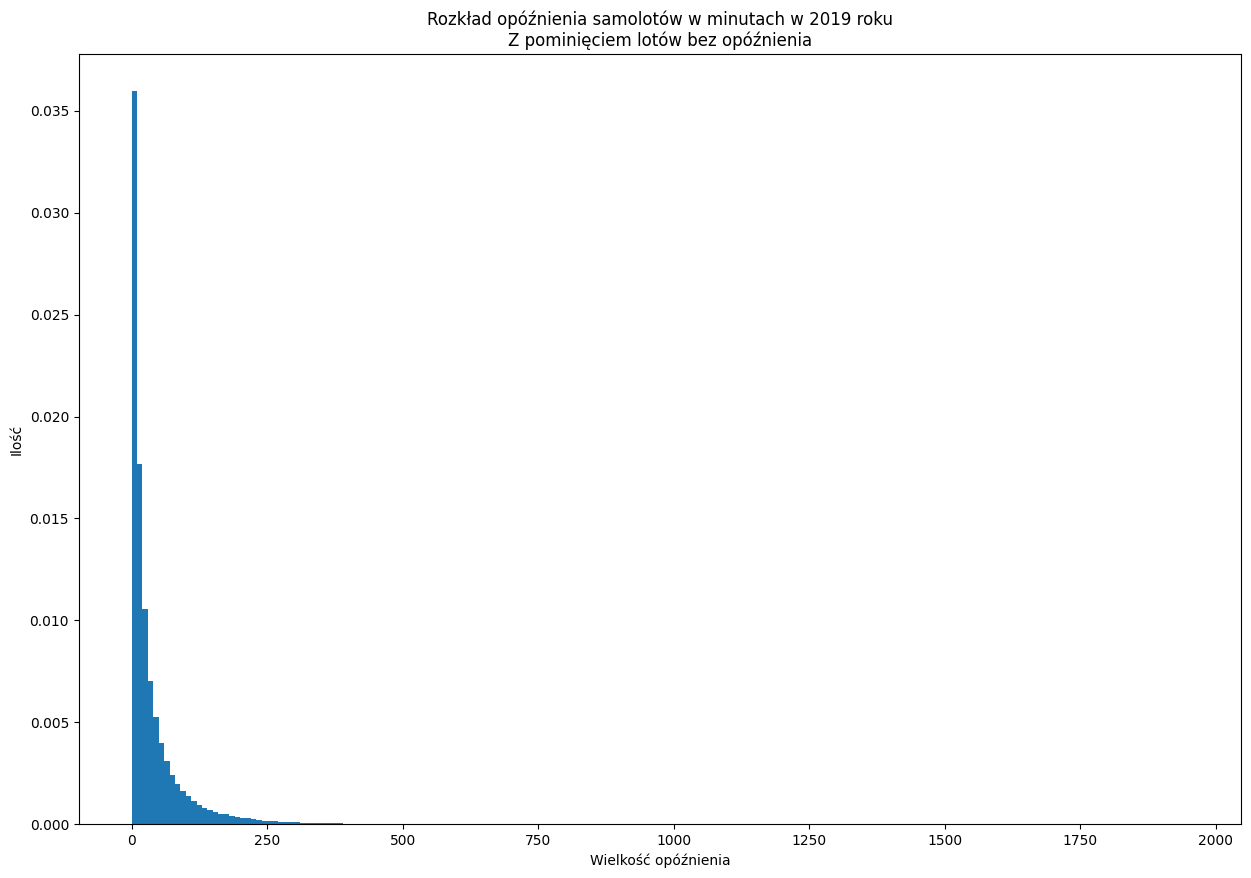

In [18]:
plt.figure(figsize=(15, 10))
plt.hist(
    x=dep_delays[dep_delays > 0],
    density=True,
    bins=bins
)

plt.title("Rozkład opóźnienia samolotów w minutach w 2019 roku\nZ pominięciem lotów bez opóźnienia")
plt.ylabel("Ilość")
plt.xlabel("Wielkość opóźnienia")


In [19]:
cutoff = int(dep_delay_statistics_df['95%'])
bins_cutted = range(0, cutoff, 10)

plt.figure(figsize=(15, 10))
plt.hist(
    x=dep_delays[(dep_delays > 0) & (dep_delays < cutoff)],
    density=True,
    bins=bins_cutted
)

plt.title("Rozkład opóźnienia samolotów w minutach w 2019 roku\nZ pominięciem lotów bez opóźnienia")
plt.ylabel("Ilość")
plt.xlabel("Wielkość opóźnienia")

Text(0.5, 0, 'Wielkość opóźnienia')

 # Analiza opóźnień


In [20]:
flight_df['is_delayed'] = 0
flight_df.loc[flight_df['dep_delay'] > 15, 'is_delayed'] = 1

/tmp/ipykernel_10009/4288832892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_df['is_delayed'] = 0


In [21]:
delayed_ratio = flight_df['is_delayed'].mean()
delayed_ratio = round(delayed_ratio, 2)

 ### Sprawdzenie


In [22]:
delayed_ratio_expected = 0.19
assert delayed_ratio == delayed_ratio_expected, f"Oczekiwanio {delayed_ratio_expected}, otrzymano {delayed_ratio}"

 # Opóźnienia vs. miesiąc kalendarzowy


In [23]:
flight_delays_by_month_df = (flight_df
                             .groupby(by=['month'])['is_delayed']
                             .mean()
                             )
flight_delays_by_month_df

month
1     0.180787
2     0.218565
3     0.176056
4     0.182794
5     0.204687
6     0.247622
7     0.216690
8     0.210322
9     0.147661
10    0.163460
11    0.139236
12    0.207854
Name: is_delayed, dtype: float64

In [24]:
plt.figure(figsize=(15, 10))

plt.bar(
    x=range(1, 13),
    height=flight_delays_by_month_df
)

plt.title("Odsetek opóźnień w 2019 roku w zależności od miesiąca kalendarzowego")
plt.ylabel("Odsetek")
plt.xlabel("Miesiąc kalendarzowy")

Text(0.5, 0, 'Miesiąc kalendarzowy')

 # Opóźnienia vs. dzień tygodnia cz. 1


In [25]:
flight_delays_by_weekday_df = (flight_df
                               .groupby(by=['day_of_week'])['is_delayed']
                               .mean()
                               )
flight_delays_by_weekday_df

day_of_week
1    0.201266
2    0.174751
3    0.182782
4    0.212168
5    0.203227
6    0.167831
7    0.192409
Name: is_delayed, dtype: float64

Text(0.5, 0, 'Miesiąc kalendarzowy')

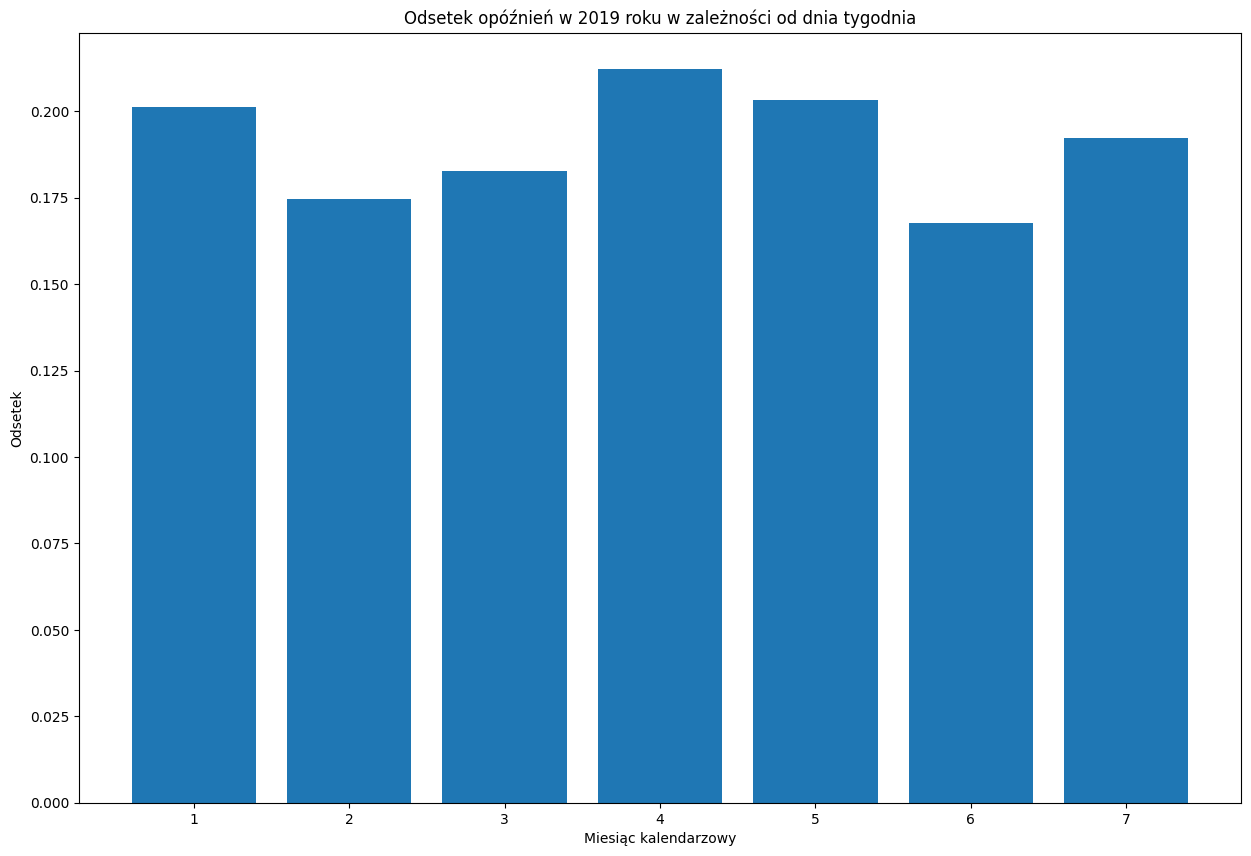

In [26]:
plt.figure(figsize=(15, 10))

plt.bar(
    x=range(1, 8),
    height=flight_delays_by_weekday_df
)

plt.title("Odsetek opóźnień w 2019 roku w zależności od dnia tygodnia")
plt.ylabel("Odsetek")
plt.xlabel("Miesiąc kalendarzowy")

 # Opóźnienia vs. dzień tygodnia cz. 2


In [27]:
flight_df["is_weekend"] = 1

not_weekend = flight_df['day_of_week'] < 6
flight_df.loc[not_weekend, 'is_weekend'] = 0

/tmp/ipykernel_10009/665828611.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_df["is_weekend"] = 1


In [28]:
flight_delays_by_weekend_df = (flight_df
                               .groupby(by=['is_weekend'])['is_delayed']
                               .mean()
                               .round(2)
                               )
flight_delays_by_weekend_df

is_weekend
0    0.19
1    0.18
Name: is_delayed, dtype: float64

In [29]:
plt.figure(figsize=(15, 10))

plt.bar(
    x=[0, 1],
    height=flight_delays_by_weekend_df
)

plt.title("Odsetek opóźnień w 2019 roku w zależności czy lot odbywał się w weekend")
plt.ylabel("Odsetek")
plt.xlabel("Miesiąc kalendarzowy")

Text(0.5, 0, 'Miesiąc kalendarzowy')

 ### Sprawdzenie


In [30]:
expected_flight_df_by_weekend = {0: 0.19, 1: 0.18}
assert flight_delays_by_weekend_df.to_dict(
) == expected_flight_df_by_weekend, f'Spodziewano się wyników: {expected_flight_df_by_weekend}\n otrzymano  {flight_delays_by_weekend_df}'

 # Opóźnienia vs. odległość lotu


In [31]:
flight_distance_analysis_df = (flight_df['distance']
                               .describe(percentiles=percentiles)
                               .round(2)
                               )
flight_distance_analysis_df

count    1095742.00
mean         758.08
std          600.43
min          100.00
10%          216.00
25%          337.00
50%          606.00
75%          937.00
90%         1721.00
95%         2475.00
99%         2586.00
max         2586.00
Name: distance, dtype: float64

Text(0.5, 0, 'Długość trasy')

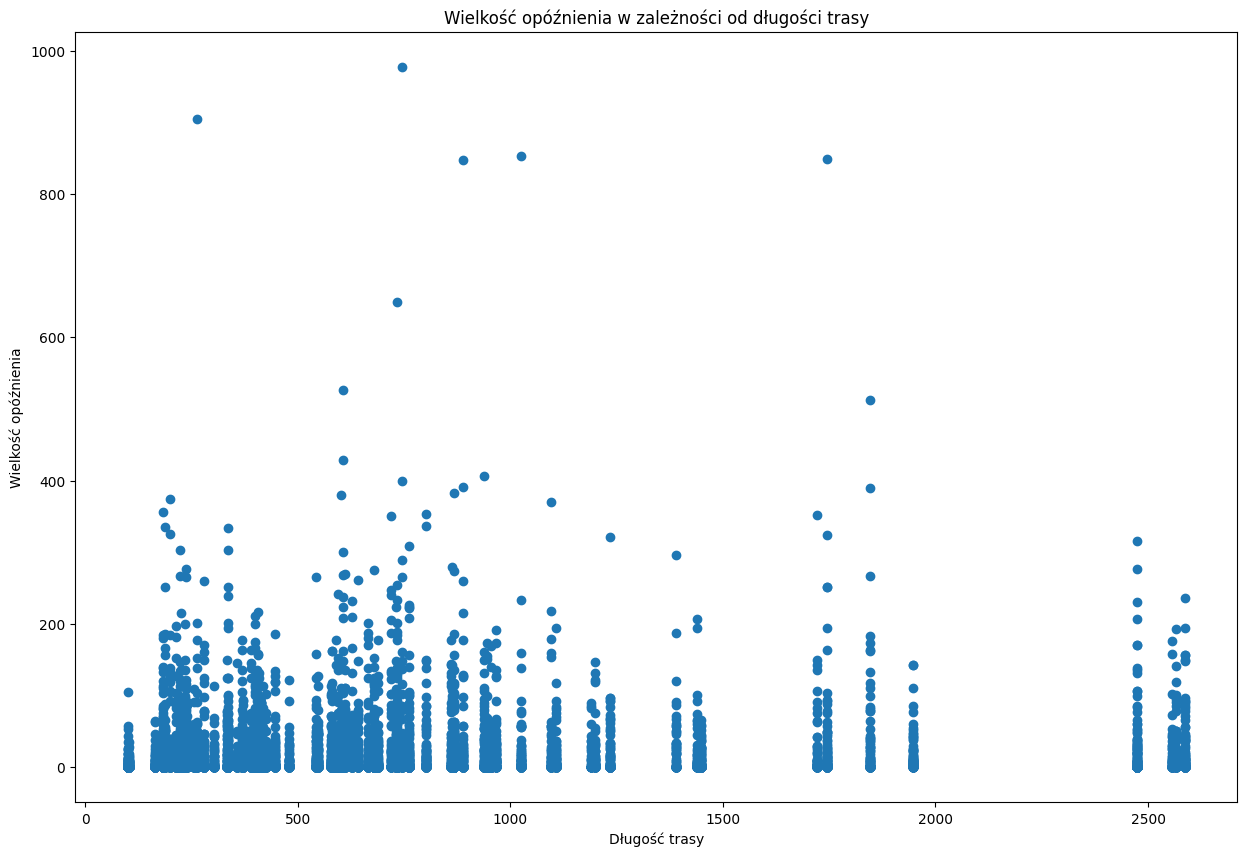

In [32]:
plt.figure(figsize=(15, 10))
df_to_plot = flight_df.sample(n=10000)

plt.scatter(
    x=df_to_plot['distance'],
    y=df_to_plot['dep_delay']
)

plt.title("Wielkość opóźnienia w zależności od długości trasy")
plt.ylabel("Wielkość opóźnienia")
plt.xlabel("Długość trasy")

In [33]:
distance_cutoff = flight_distance_analysis_df['95%']
distance_cutoff = int(distance_cutoff)

flight_df = flight_df.loc[flight_df['distance'] <= distance_cutoff]

### Sprawdzenie

In [34]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

In [35]:
bins = range(0, distance_cutoff, 100)
flight_df['distance_agg'] = pd.cut(flight_df['distance'], bins)

flight_delays_by_distance_agg_df = (flight_df
                                    .groupby(by=['distance_agg'])['is_delayed']
                                    .mean()
                                    )

flight_delays_by_distance_agg_df

distance_agg
(0, 100]        0.059320
(100, 200]      0.168884
(200, 300]      0.181882
(300, 400]      0.195604
(400, 500]      0.171409
(500, 600]      0.165023
(600, 700]      0.197254
(700, 800]      0.235472
(800, 900]      0.211396
(900, 1000]     0.224219
(1000, 1100]    0.195799
(1100, 1200]    0.190201
(1200, 1300]    0.209276
(1300, 1400]    0.246045
(1400, 1500]    0.160253
(1500, 1600]         NaN
(1600, 1700]         NaN
(1700, 1800]    0.206757
(1800, 1900]    0.269311
(1900, 2000]    0.202109
(2000, 2100]         NaN
(2100, 2200]         NaN
(2200, 2300]         NaN
(2300, 2400]         NaN
Name: is_delayed, dtype: float64

Text(0.5, 0, 'Długość trasy')

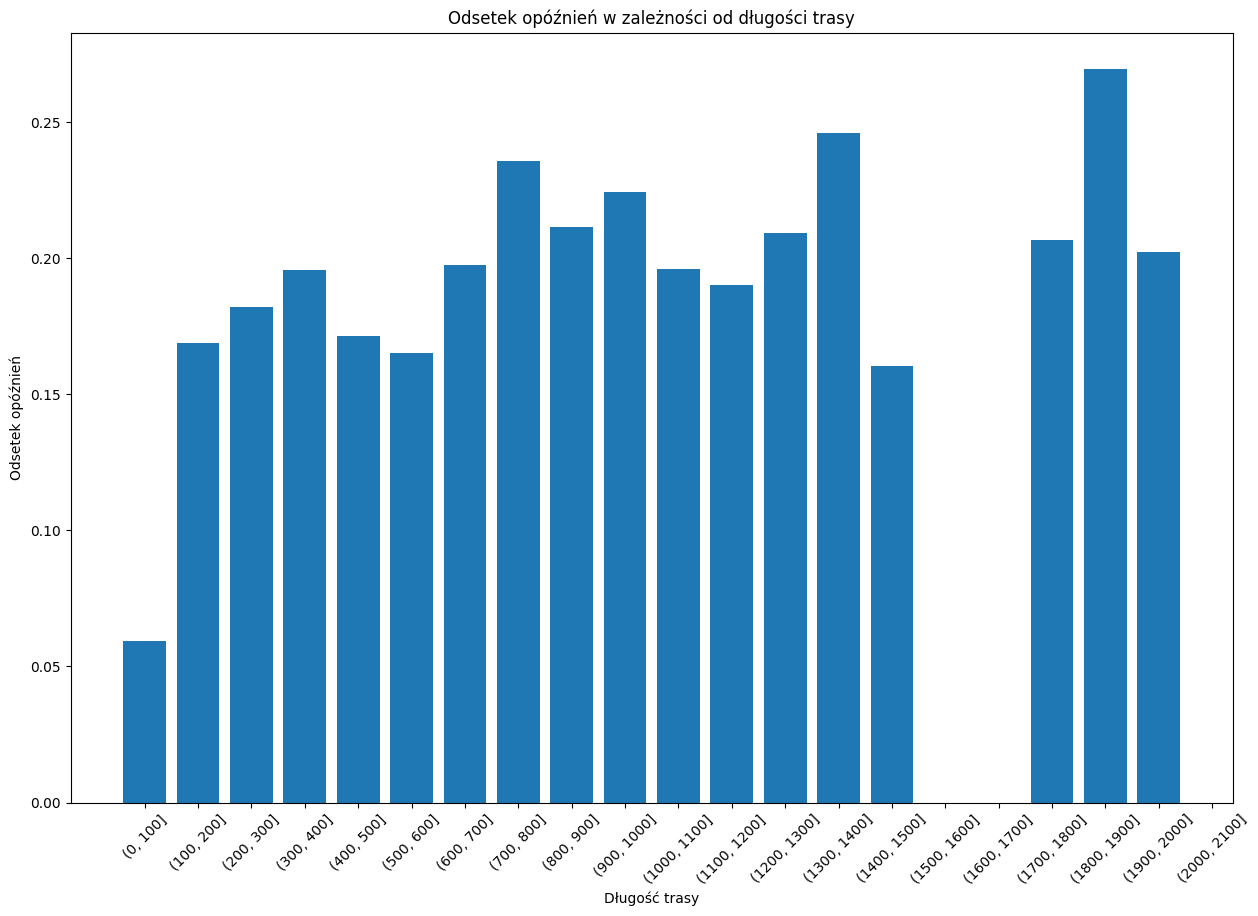

In [36]:
plt.figure(figsize=(15, 10))

plt.bar(
    x=flight_delays_by_distance_agg_df.index.astype(str),
    height=flight_delays_by_distance_agg_df
)

plt.title("Odsetek opóźnień w zależności od długości trasy")
plt.ylabel("Odsetek opóźnień")

plt.xticks(rotation=45)
plt.xlabel("Długość trasy")

 ## Sprawdzenie


In [37]:
assert 'distance_agg' in flight_df.columns, 'Nie odnaleziono kolumny distance_agg w ramce flight_df'

 # Opóźnienia vs. grupa odległości


Tutaj wyznacz odcinki, dla których zostały wyznaczone poszczególne grupy

In [38]:
flight_distance_by_distance_group = (flight_df
                                     .groupby(by=['distance_group'])['distance']
                                     .agg(['min', 'max'])
                                     )
flight_distance_by_distance_group

min     max
distance_group                
1                100.0   239.0
2                255.0   480.0
3                544.0   746.0
4                762.0   967.0
5               1024.0  1235.0
6               1389.0  1448.0
7               1721.0  1744.0
8               1846.0  1947.0
10              2475.0  2475.0

In [39]:
flight_delays_by_distance_group_df = (flight_df
                            .groupby(by=['distance_group'])['is_delayed']
                            .mean()
                            )
flight_delays_by_distance_group_df

distance_group
1     0.158558
2     0.187302
3     0.198168
4     0.216511
5     0.196224
6     0.189574
7     0.206757
8     0.235443
10    0.166569
Name: is_delayed, dtype: float64

Text(0.5, 0, 'Długość trasy')

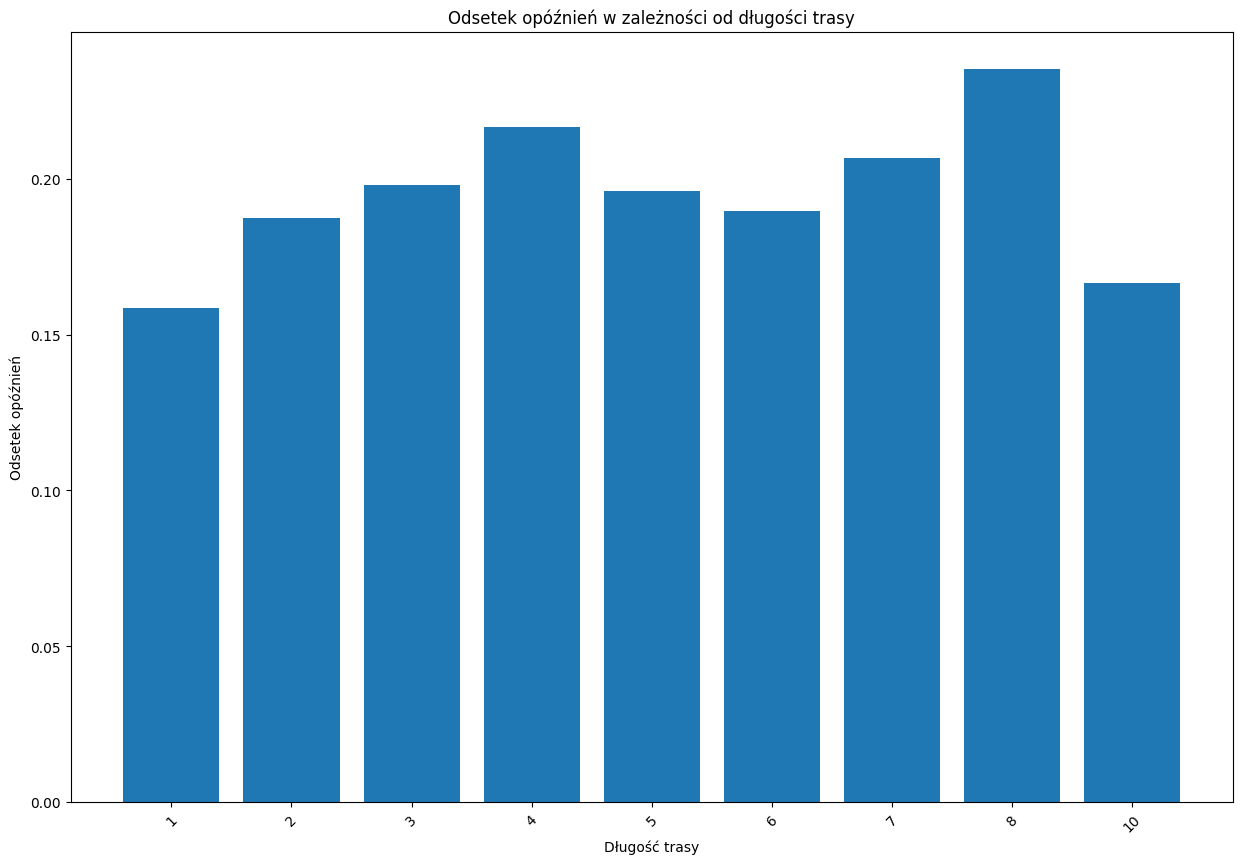

In [40]:
plt.figure(figsize=(15, 10))

plt.bar(
    x=flight_delays_by_distance_group_df.index.astype(str),
    height=flight_delays_by_distance_group_df
)

plt.title("Odsetek opóźnień w zależności od długości trasy")
plt.ylabel("Odsetek opóźnień")

plt.xticks(rotation=45)
plt.xlabel("Długość trasy")

Zapisz ramki

In [41]:
flight_df.to_csv('../data/processed/flight_df_01.csv', sep=';')